# Fake News Detection Using the LIAR Dataset

<b>Overview</b>

Our project focuses on developing a machine learning-based system for fake news detection,
using the LIAR dataset, which contains 12.8K short statements labelled by fact-checkers on
Politifact.com. Given the rapid spread of misinformation in the digital age, we aim to create a
system that can effectively classify the truthfulness of statements, providing a basis for
automated fact-checking.

Action Plan:

1. **Comprehensive Data Analysis**: Employ diverse methods to analyze the dataset thoroughly.  
2. **Distribution of Fake News Data**: Examine and visualize how fake news is distributed across various categories.  
3. **Label Analysis**: Use plots and word clouds to explore the distribution and significance of fake news labels.  
4. **Fake News Statement Analysis**: Perform in-depth analysis of fake news statements for patterns and insights.  
5. **Data Cleaning for Label Support**: Refine fake news statements to ensure they effectively support the associated labels.  
6. **Subject Analysis**: Analyze subjects with graphical representations and group subjects to better distinguish fake news labels.  
7. **Speaker Analysis**: Examine speakers using graphs to uncover patterns and trends.  
8. **Speaker's Job Title Analysis**: Explore speaker job titles with graphs and group them for improved label distinction.  
9. **State Analysis**: Visualize and analyze state-level information to identify relevant patterns.  
10. **Party Affiliation Analysis**: Use graphs to study party affiliations and group them for better differentiation of fake news labels.  
11. **Venue Analysis**: Analyze venues with graphs and group them to improve the distinction of fake news labels.  
12. **Numeric Feature Analysis**: Explore numerical data features with detailed plots.  
13. **Model Training and Evaluation**: Train and evaluate machine learning models to classify and understand fake news.  
14. **Model Comparison**: Conduct a comparative analysis of all trained models to identify the best-performing one.  
15. **Comprehensive Report**: Present a detailed report summarizing all findings, analyses, and conclusions.  

#### Importing Python Libraries

In [60]:
import re
import os
import nltk
import torch
import string
import warnings
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from torch.utils.data import DataLoader, Dataset
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
warnings.filterwarnings("ignore")

#### Data Source

Source of Data:
https://www.cs.ucsb.edu/~william/data/liar_dataset

In [4]:
df = pd.read_csv("Liar_Dataset.csv") 
df_bert = df[['label']].copy()

#### EDA

In [5]:
df.columns

Index(['[ID].json', 'label', 'statement', 'subject(s)', 'speaker',
       'speaker's job title', 'state info', 'party affiliation',
       'barely true counts', 'false counts', 'half true counts',
       'mostly true counts', 'pants on fire counts', 'venue'],
      dtype='object')

In [6]:
df.shape

(12787, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12787 entries, 0 to 12786
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   [ID].json             12787 non-null  object
 1   label                 12787 non-null  object
 2   statement             12787 non-null  object
 3   subject(s)            12787 non-null  object
 4   speaker               12787 non-null  object
 5   speaker's job title   9221 non-null   object
 6   state info            10038 non-null  object
 7   party affiliation     12787 non-null  object
 8   barely true counts    12787 non-null  int64 
 9   false counts          12787 non-null  int64 
 10  half true counts      12787 non-null  int64 
 11  mostly true counts    12787 non-null  int64 
 12  pants on fire counts  12787 non-null  int64 
 13  venue                 12658 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.4+ MB


In [8]:
df.head()

[ID].json       label                                          statement  \
0  11972.json        TRUE  Building a wall on the U.S.-Mexico border will...   
1  11685.json       FALSE  Wisconsin is on pace to double the number of l...   
2  11096.json       FALSE  Says John McCain has done nothing to help the ...   
3   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...   
4   9524.json  pants-fire  When asked by a reporter whether hes at the ce...   

                                          subject(s)  \
0                                        immigration   
1                                               jobs   
2                    military,veterans,voting-record   
3  medicare,message-machine-2012,campaign-adverti...   
4  campaign-finance,legal-issues,campaign-adverti...   

                            speaker   speaker's job title state info  \
0                        rick-perry              Governor      Texas   
1                 katrina-shankland  State representative  Wisconsin   
2                      donald-trump       President-Elect   New York   
3                     rob-cornilles            consultant     Oregon   
4  state-democratic-party-wisconsin                   NaN  Wisconsin   

  party affiliation  barely true counts  false counts  half true counts  \
0        republican                  30            30                42   
1          democrat                   2             1                 0   
2        republican                  63           114                51   
3        republican                   1             1                 3   
4          democrat                   5             7                 2   

   mostly true counts  pants on fire counts                         venue  
0                  23                    18               Radio interview  
1                   0                     0             a news conference  
2                  37                    61  comments on ABC's This Week.  
3                   1                     1                  a radio show  
4                   2                     7                   a web video

<b>Deleting the [ID].json coloumn because it's a file name</b>

In [9]:
df.drop(['[ID].json'], axis=1, inplace=True)

<b>Checking duplicate data</b>

In [10]:
print('Rows before duplicate deletion: ', len(df))
df=df.drop_duplicates()
print('Rows after duplicate deletion: ', len(df))

Rows before duplicate deletion:  12787
Rows after duplicate deletion:  12786


<b>Checking null values</b>

In [11]:
np.sum(df.isnull().any(axis=1))

4354

In [12]:
df.isnull().sum()

label                      0
statement                  0
subject(s)                 0
speaker                    0
speaker's job title     3566
state info              2749
party affiliation          0
barely true counts         0
false counts               0
half true counts           0
mostly true counts         0
pants on fire counts       0
venue                    129
dtype: int64

<b>Replacing NaN values with missing values</b>

In [13]:
df.replace('', np.nan, inplace=True)

In [14]:
df['venue']= df['venue'].replace(np.nan, 'Unknown')
df["speaker's job title"]= df["speaker's job title"].replace(np.nan, 'Unknown')
df["state info"]= df["state info"].replace(np.nan, 'Unknown')
# Transform the 'label' column in df_bert
df_bert['label'] = [1 if x in ["true", "mostly-true"] else 0 for x in df_bert['label']]

In [15]:
df.isnull().sum()

label                   0
statement               0
subject(s)              0
speaker                 0
speaker's job title     0
state info              0
party affiliation       0
barely true counts      0
false counts            0
half true counts        0
mostly true counts      0
pants on fire counts    0
venue                   0
dtype: int64

<b>Identify numeric columns (e.g., likes, shares, scores).</b>

In [16]:
num_cols = ['barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts']
num_cols

['barely true counts',
 'false counts',
 'half true counts',
 'mostly true counts',
 'pants on fire counts']

In [17]:
#categorical columns
cate_cols = df.columns.drop('label').drop(num_cols)
cate_cols

Index(['statement', 'subject(s)', 'speaker', 'speaker's job title',
       'state info', 'party affiliation', 'venue'],
      dtype='object')

In [18]:
df[cate_cols].apply(lambda x: x.nunique(), axis=0)

statement              12761
subject(s)              4534
speaker                 3308
speaker's job title     1354
state info                84
party affiliation         24
venue                   5142
dtype: int64

#### Labelling

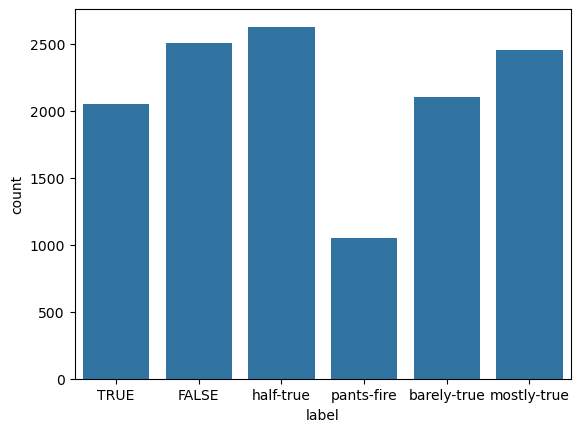

In [19]:
sns.countplot(data=df, x = "label")
plt.show()

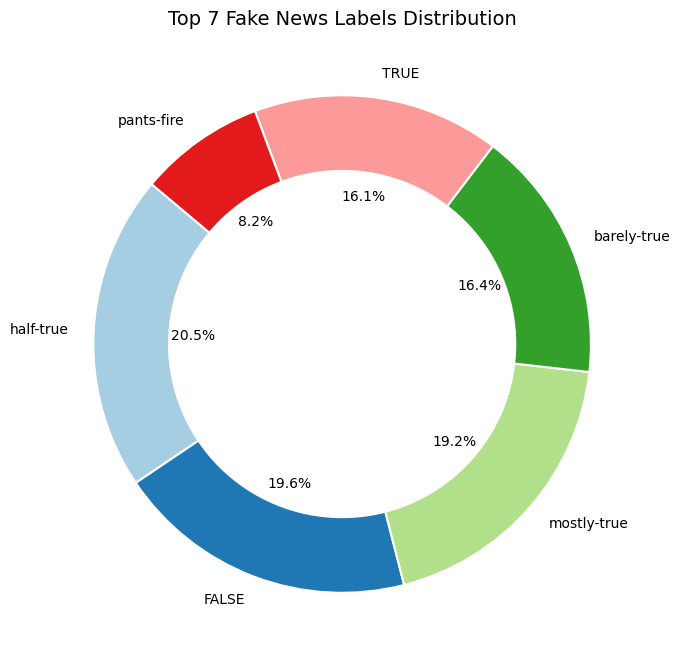

In [20]:
# Count the top 7 labels
label_counts = df["label"].value_counts().head(7)

# Plotting a pie chart with enhancements
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
        startangle=140, wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
        colors=plt.cm.Paired.colors)

# Add a center circle for a donut effect (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Add a title
plt.title("Top 7 Fake News Labels Distribution", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
df["label"].value_counts()

label
half-true      2626
FALSE          2504
mostly-true    2454
barely-true    2102
TRUE           2053
pants-fire     1047
Name: count, dtype: int64

<b>Looking at the words which are in the barely-true news</b>

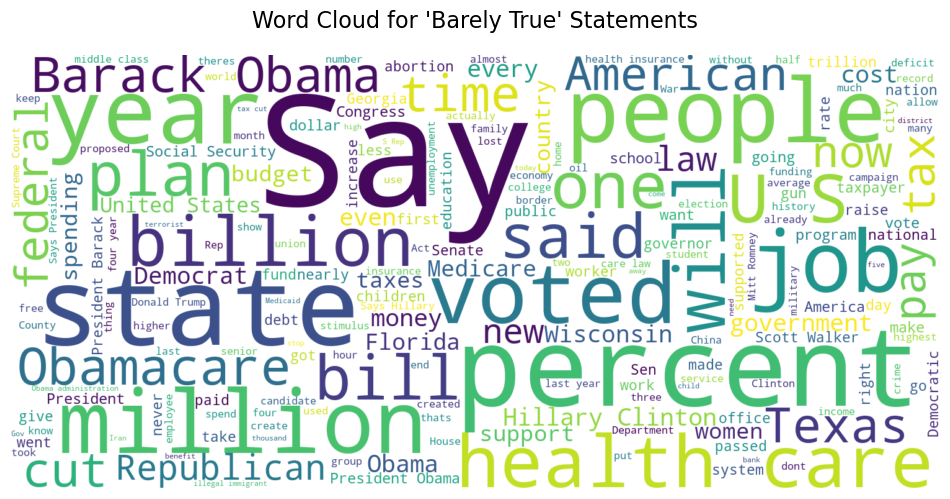

In [22]:
# Filter statements for the 'barely-true' label
statements = df[df['label'] == 'barely-true']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='white', 
    colormap='viridis'
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Barely True' Statements", fontsize=16, pad=20)
plt.show()

<b> Words which are in half-true </b>

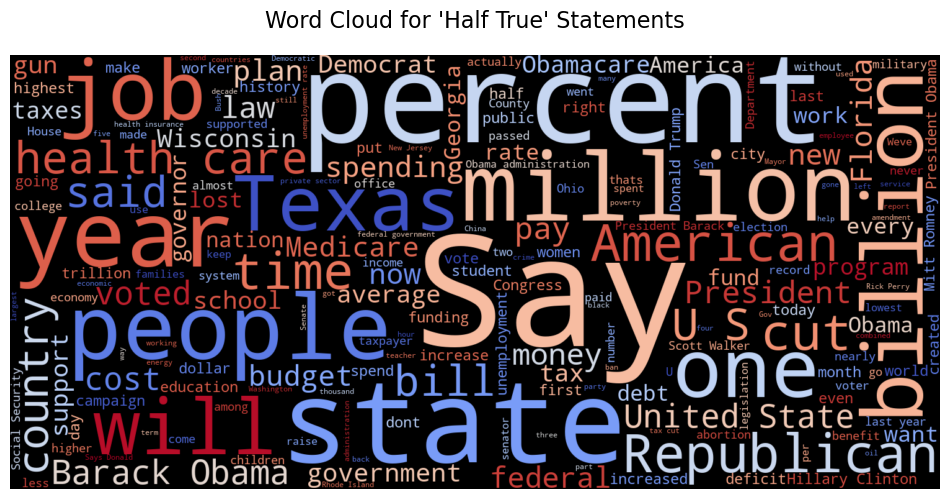

In [23]:
# Filter statements for the 'half-true' label
statements = df[df['label'] == 'half-true']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='black', 
    colormap='coolwarm'  # Adds a colorful gradient
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Half True' Statements", fontsize=16, color='black', pad=20)
plt.show()

<b> Words which are mostly-true </b>

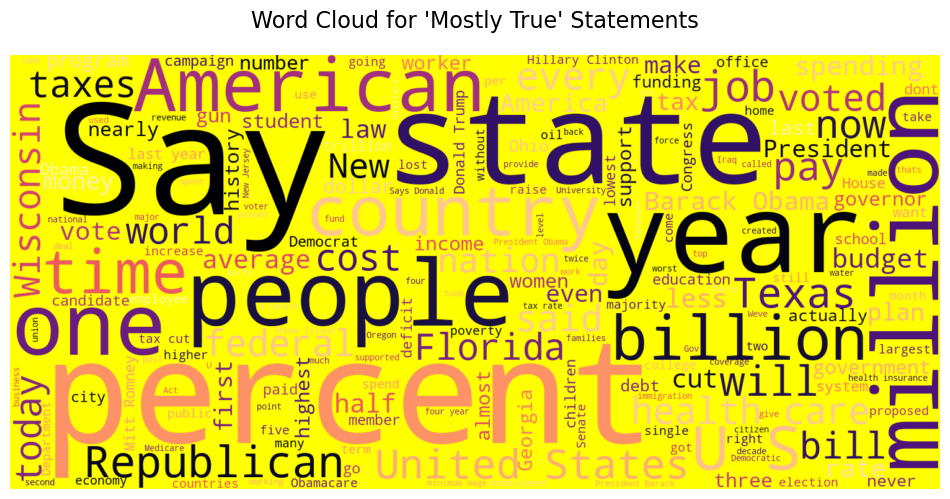

In [24]:
# Filter statements for the 'mostly-true' label
statements = df[df['label'] == 'mostly-true']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='yellow',  # Yellow background
    colormap='magma'           # Contrasting color palette
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Mostly True' Statements", fontsize=16, color='black', pad=20)
plt.show()

<b> Words which are true </b>

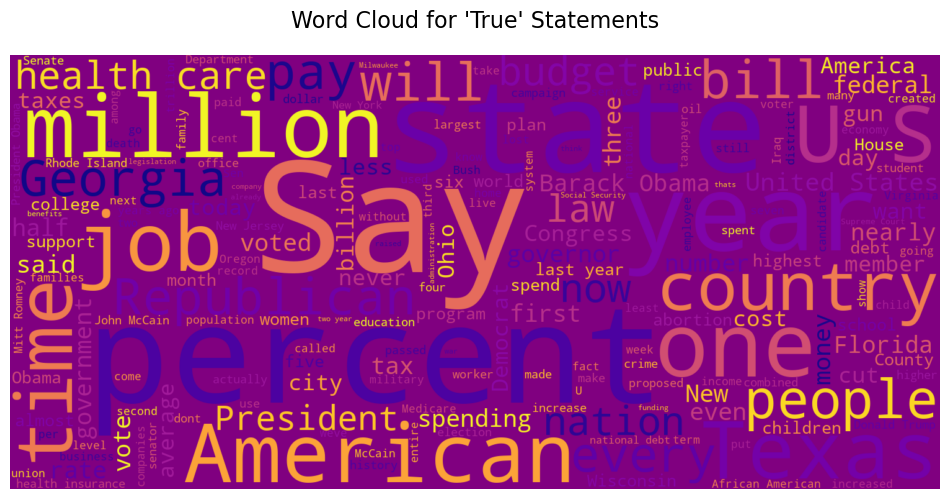

In [25]:
# Filter statements for the 'TRUE' label
statements = df[df['label'] == 'TRUE']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='purple',  # Purple background
    colormap='plasma'          # Vibrant colormap for contrast
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'True' Statements", fontsize=16, color='black', pad=20)
plt.show()

<b> Words which are false </b>

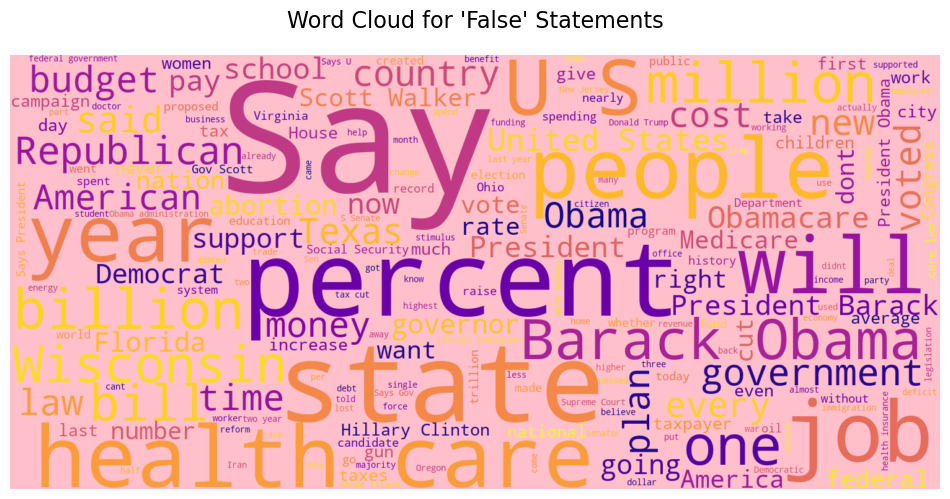

In [26]:
# Filter statements for the 'TRUE' label
statements = df[df['label'] == 'FALSE']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='pink',  # Purple background
    colormap='plasma'          # Vibrant colormap for contrast
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'False' Statements", fontsize=16, color='black', pad=20)
plt.show()

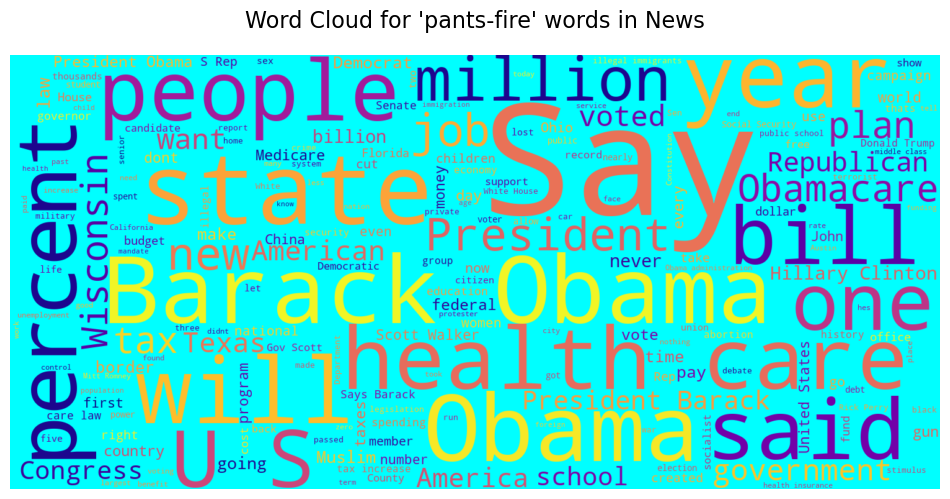

In [27]:
# Filter statements for the 'pants-fire' label
statements = df[df['label'] == 'pants-fire']['statement']

# Combine all statements into a single string
text = " ".join(statements.astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=1500, 
    height=700, 
    max_font_size=250, 
    background_color='aqua',  # Purple background
    colormap='plasma'          # Vibrant colormap for contrast
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'pants-fire' words in News", fontsize=16, color='black', pad=20)
plt.show()

#### Pre-Process text

In [28]:
st = nltk.PorterStemmer()
lm = nltk.WordNetLemmatizer()

In [29]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
STOPWORDS = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

In [30]:
df['statement']=df['statement'].str.lower()
df["statement"] = df["statement"].apply(lambda text: cleaning_stopwords(text))
df["statement"] = df["statement"].apply(lambda x: cleaning_punctuations(x))
df["statement"] = df["statement"].apply(lambda x: cleaning_repeating_char(x))
df["statement"] = df["statement"].apply(lambda x: cleaning_URLs(x))
df["statement"] = df["statement"].apply(lambda x: cleaning_email(x))
df["statement"] = df["statement"].apply(lambda x: cleaning_numbers(x))

In [31]:
tokenizer = RegexpTokenizer(r'\w+')
df["statement"] = df["statement"].apply(tokenizer.tokenize)
df["statement"] = df["statement"].apply(lambda x: stemming_on_text(x))
df["statement"] = df["statement"].apply(lambda x: lemmatizer_on_text(x))

In [32]:
words = [word for tokens in df["statement"] for word in tokens]
lenght_of_each_sentence = [len(tokens) for tokens in df["statement"]]
vocabulary  = sorted(list(set(words)))
print("There are %s words in total, with vocabulary size of %s" % (len(words), len(vocabulary)))

There are 136875 words in total, with vocabulary size of 13710


<b>Top 25 frequently words in news statement text</b>

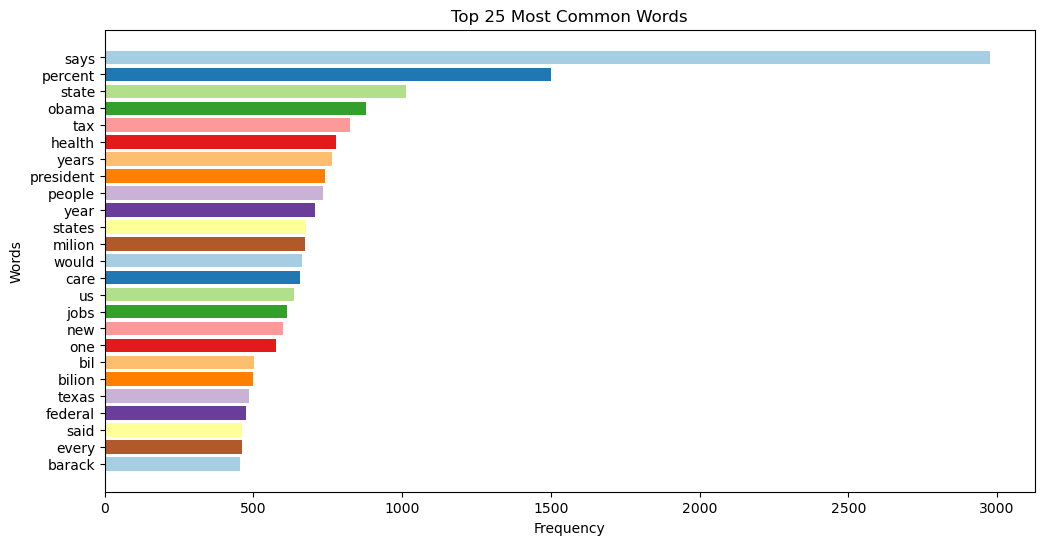

In [33]:
counts_of_words = Counter(words)
most_common_words = counts_of_words.most_common(25)

# Separate words and counts
words, counts = zip(*most_common_words)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(words, counts, color=plt.cm.Paired.colors)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 25 Most Common Words')
plt.gca().invert_yaxis()  # Invert to show the most frequent at the top
plt.show()

#### Fixing coloumsn by applying Tokenization, removing stop words, apply stemming, visualization

1. Subject Column

In [34]:
df["subject(s)"]= df["subject(s)"].str.replace(",", " ")
subjectTokenize = []
for sen in df["subject(s)"]:
    subjectTokenize.append(word_tokenize(sen))

filteredsubjects = []
for words in subjectTokenize:
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    filteredsubjects.append(wordsFiltered)

ps = PorterStemmer() 
index = 0    
for words in filteredsubjects:
    subjects=""
    for w in words: 
        subjects=subjects+ps.stem(w)+" "
    df.at[index, "subject(s)"] = subjects
    index += 1

df["dummp"]=df["subject(s)"]
df["dummp"]=df["dummp"].str.strip()
df.loc[df["dummp"].str.contains('job|worker'), 'dummp'] = 'jobs'
df.loc[df["dummp"].str.contains('hous'), 'dummp'] = 'budget'
df.loc[df["dummp"].str.contains('county-budget'), 'dummp'] = 'budget'
df.loc[df["dummp"].str.contains('federal-budget'), 'dummp'] = 'budget'
df.loc[df["dummp"].str.contains('state-budget|city-budget'), 'dummp'] = 'budget'
df.loc[df["dummp"].str.contains('state-fin'), 'dummp'] = 'budget'
df.loc[df["dummp"].str.contains('edu'), 'dummp'] = 'education'
df.loc[df["dummp"].str.contains('economi|incom|tax|debt|market-regul|financial-regul|trade|small-busi'), 'dummp'] = 'economy'
df.loc[df["dummp"].str.contains('militari|veteran'), 'dummp'] = 'military'
df.loc[df["dummp"].str.contains('government-effici|city-govern|county-govern|government-regul|supreme-court|state'), 'dummp'] = 'government'

df.loc[df["dummp"].str.contains('health-car|medicar|abort|public-health'), 'dummp'] = 'health-care'
df.loc[df["dummp"].str.contains('crime|gun|public-safeti|legal-issu|terror|homeland-secur'), 'dummp'] = 'crime'

df.loc[df["dummp"].str.contains('climate-chang|environ|anim'), 'dummp'] = 'environment'

df.loc[df["dummp"].str.contains('foreign-polici|voting-record|congress|elect|politics'), 'dummp'] = 'politics'

df.loc[df["dummp"].str.contains('children|immigr|women|popul|poverti|social-secur|religion'), 'dummp'] = 'social'

df.loc[~df["dummp"].str.contains('jobs|budget|education|economy|military|government|health-care|crime|environment|politics|social'), 'dummp'] = 'other'


In [35]:
df["subject(s)"]=df["dummp"]
df=df.drop(columns=['dummp'])

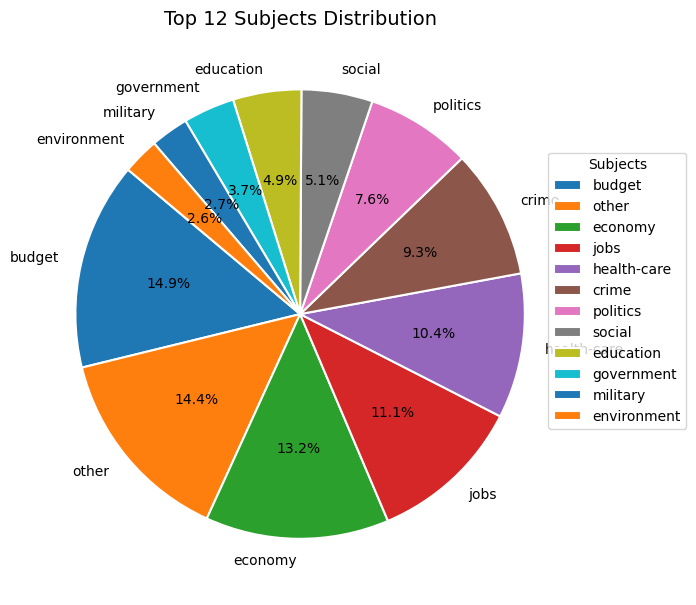

In [36]:
# Count the top 12 subjects
subject_counts = df["subject(s)"].value_counts().head(12)

# Plot the pie chart
plt.figure(figsize=(7, 7))
subject_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.tab10.colors
)

# Add title and legend
plt.title("Top 12 Subjects Distribution", fontsize=14)
plt.ylabel('')  # Remove default ylabel for a cleaner look
plt.legend(subject_counts.index, bbox_to_anchor=(1.2, 0.8), title="Subjects")
plt.tight_layout()
plt.show()

2. Speaker Column

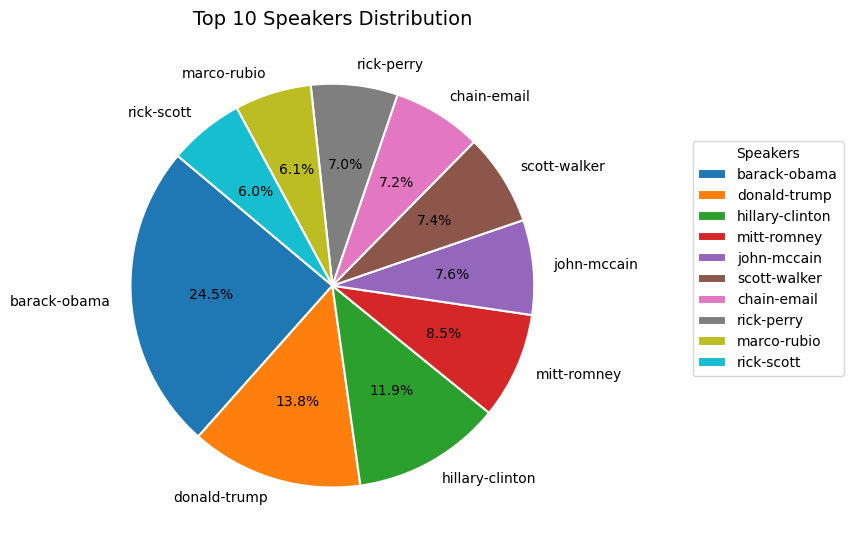

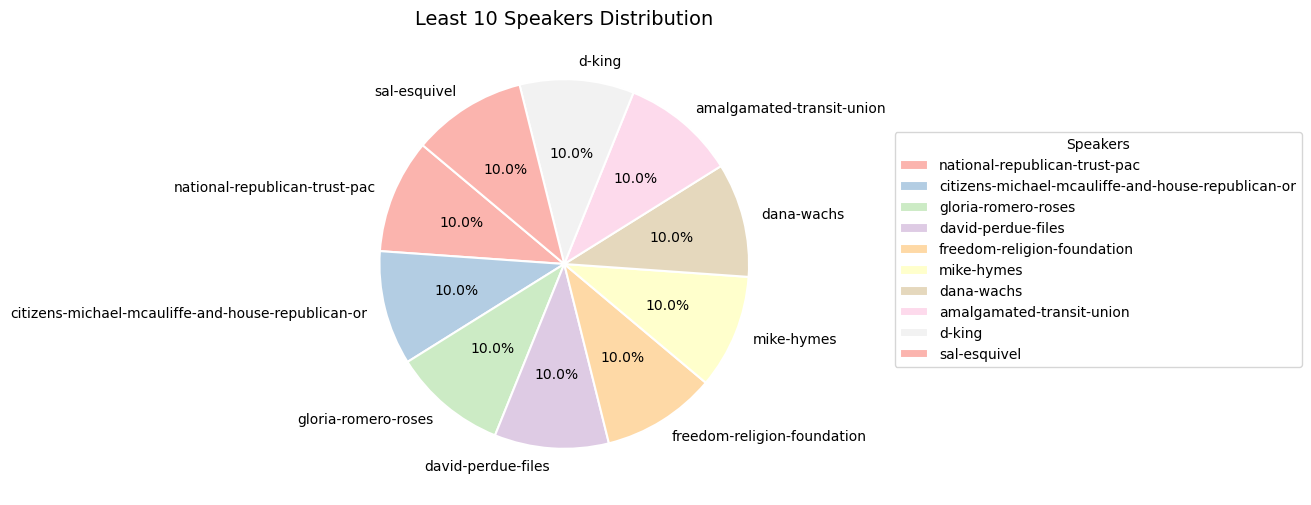

In [37]:
# Calculate speaker counts
speaker_counts = df["speaker"].value_counts()

# Top 10 speakers
top_10_speakers = speaker_counts.head(10)

# Least 10 speakers (only those who have data)
least_10_speakers = speaker_counts.tail(10)

# Plot Top 10 speakers
plt.figure(figsize=(7, 7))
top_10_speakers.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.tab10.colors
)
plt.title("Top 10 Speakers Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for a cleaner look
plt.legend(top_10_speakers.index, bbox_to_anchor=(1.2, 0.8), title="Speakers")
plt.tight_layout()
plt.show()

# Plot Least 10 speakers
plt.figure(figsize=(6, 6))
least_10_speakers.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.Pastel1.colors
)
plt.title("Least 10 Speakers Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for a cleaner look
plt.legend(least_10_speakers.index, bbox_to_anchor=(1.2, 0.8), title="Speakers")
plt.tight_layout()
plt.show()

3. Speaker Job Column

In [38]:
df["speaker's job title"] = df["speaker's job title"].apply(str)
jobTokenize = []
for sen in df["speaker's job title"]:
    jobTokenize.append(word_tokenize(sen))

filteredjobs = []
for words in jobTokenize:
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    filteredjobs.append(wordsFiltered)

index = 0    
for words in filteredjobs:

    job=""
    for w in words: 
        job=job+ps.stem(w)+" "
    df.at[index, "speaker's job title"] = job
    index += 1

In [39]:
df["dummp"]=df["speaker's job title"]
df["dummp"]=df["dummp"].str.strip()
df.loc[df["dummp"].str.contains('repres'), 'dummp'] = 'U.S. representative'
df.loc[df["dummp"].str.contains('governor'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('state'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('congressman'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('senat'), 'speaker'] = 'state representative'
df.loc[df["dummp"].str.contains('congresswoman'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('deleg'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('mayor'), 'dummp'] = 'state representative'
df.loc[df["dummp"].str.contains('presid'), 'dummp'] = 'president'
df.loc[df["dummp"].str.contains('director'), 'dummp'] = 'office director'
df.loc[df["dummp"].str.contains('group'), 'dummp'] = 'company'
df.loc[df["dummp"].str.contains('chairman'), 'dummp'] = 'company'
df.loc[df["dummp"].str.contains('program'), 'dummp'] = 'company'
df.loc[df["dummp"].str.contains('counti'), 'dummp'] = 'government'
df.loc[df["dummp"].str.contains('attorney'), 'dummp'] = 'government'
df.loc[df["dummp"].str.contains('govern'), 'dummp'] = 'government'
df.loc[df["dummp"].str.contains('media'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('blog'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('show'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('host'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('radio'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('tv'), 'dummp'] = 'media'
df.loc[df["dummp"].str.contains('unknown'), 'dummp'] = 'unknown'
df.loc[~df["dummp"].str.contains('state representative|president|office director|company|U.S. representative|government|media|unknown'), 'dummp'] = 'other'

In [40]:
df["speaker's job title"]=df["dummp"]
df=df.drop(columns=['dummp'])

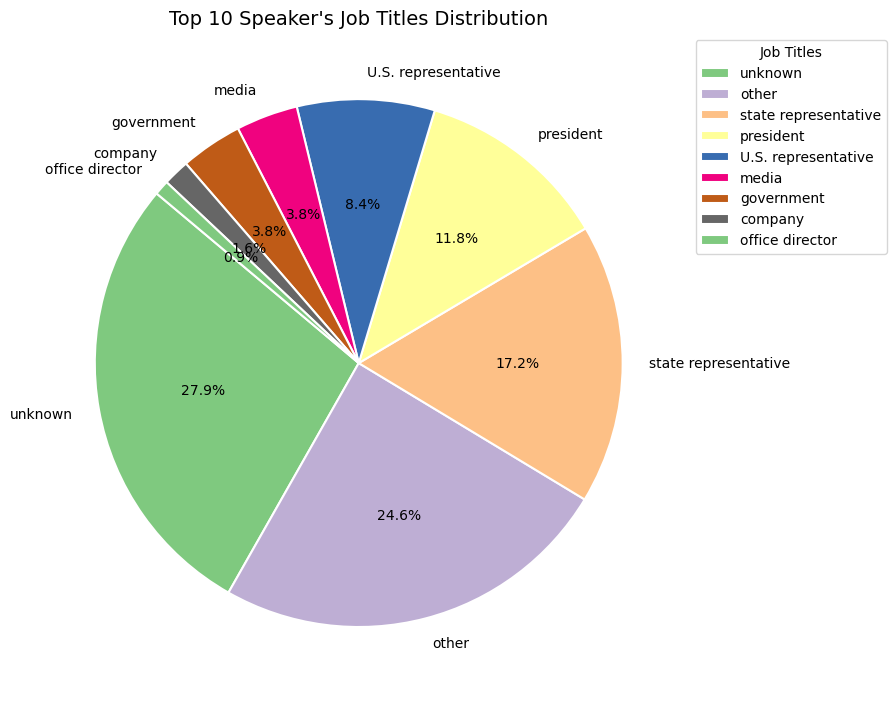

In [41]:
# Get the top 10 job titles
job_title_counts = df["speaker's job title"].value_counts().head(10)

# Plot the pie chart
plt.figure(figsize=(9, 9))
job_title_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.Accent.colors  # Use a distinct color palette
)

# Add title and legend
plt.title("Top 10 Speaker's Job Titles Distribution", fontsize=14)
plt.ylabel('')  # Remove default ylabel for cleaner look
plt.legend(job_title_counts.index, bbox_to_anchor=(1, 1), title="Job Titles")
plt.tight_layout()
plt.show()

4. State Info Column

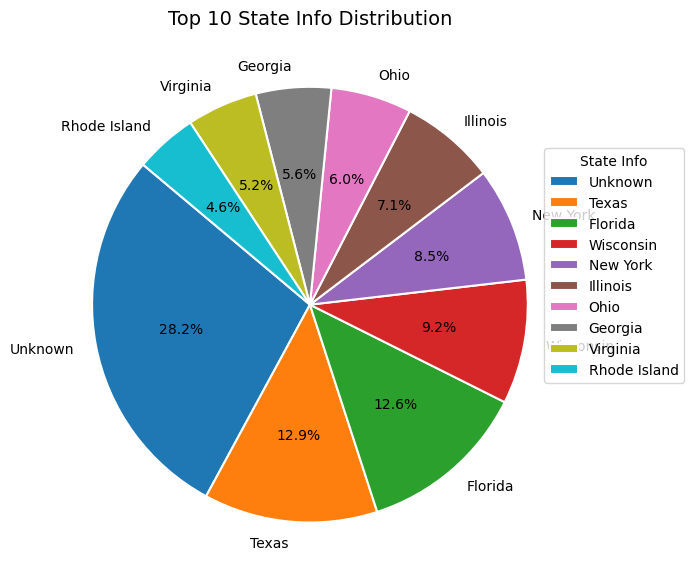

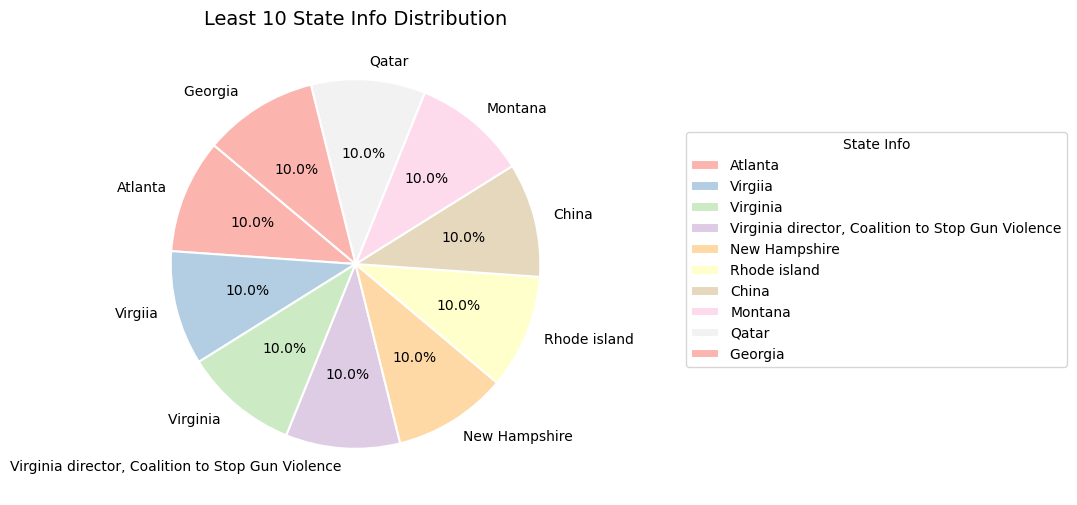

In [42]:
# Calculate state info counts
state_info = df["state info"].value_counts()

# Top 10 state_info
top_10_state_info = state_info.head(10)

# Least 10 state_info (only those who have data)
least_10_state_info = state_info.tail(10)

# Plot Top 10 speakers
plt.figure(figsize=(7, 7))
top_10_state_info.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.tab10.colors
)
plt.title("Top 10 State Info Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for a cleaner look
plt.legend(top_10_state_info.index, bbox_to_anchor=(1.2, 0.8), title="State Info")
plt.tight_layout()
plt.show()

# Plot Least 10 state_info
plt.figure(figsize=(6, 6))
least_10_state_info.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.Pastel1.colors
)
plt.title("Least 10 State Info Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for a cleaner look
plt.legend(least_10_state_info.index, bbox_to_anchor=(1.2, 0.8), title="State Info")
plt.tight_layout()
plt.show()

5. party affiliation Column

In [43]:
df['party affiliation'].unique()

array(['republican', 'democrat', 'none', 'activist', 'organization',
       'libertarian', 'journalist', 'independent', 'columnist',
       'state-official', 'business-leader', 'talk-show-host',
       'government-body', 'newsmaker', 'county-commissioner',
       'constitution-party', 'labor-leader', 'education-official',
       'tea-party-member', 'green', 'liberal-party-canada', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action', nan],
      dtype=object)

Creating four party affiliation
- republican
- democrat
- Unknown
- Other

In [44]:
df["party affiliation"]= df["party affiliation"].replace('none', 'Unknown')
df["party affiliation"]= df["party affiliation"].replace('activist', 'Other')
df["party affiliation"]= df["party affiliation"].replace('organization', 'Other')
df["party affiliation"]= df["party affiliation"].replace('libertarian', 'Other')
df["party affiliation"]= df["party affiliation"].replace('journalist', 'Other')
df["party affiliation"]= df["party affiliation"].replace('columnist', 'Other')
df["party affiliation"]= df["party affiliation"].replace('state-official', 'Other')
df["party affiliation"]= df["party affiliation"].replace('business-leader', 'Other')
df["party affiliation"]= df["party affiliation"].replace('talk-show-host', 'Other')
df["party affiliation"]= df["party affiliation"].replace('government-body', 'Other')
df["party affiliation"]= df["party affiliation"].replace('newsmaker', 'Other')
df["party affiliation"]= df["party affiliation"].replace('county-commissioner', 'Other')
df["party affiliation"]= df["party affiliation"].replace('constitution-party', 'Other')
df["party affiliation"]= df["party affiliation"].replace('labor-leader', 'Other')
df["party affiliation"]= df["party affiliation"].replace('education-official', 'Other')
df["party affiliation"]= df["party affiliation"].replace('tea-party-member', 'Other')
df["party affiliation"]= df["party affiliation"].replace('green', 'Other')
df["party affiliation"]= df["party affiliation"].replace('liberal-party-canada', 'Other')
df["party affiliation"]= df["party affiliation"].replace('Moderate', 'Other')
df["party affiliation"]= df["party affiliation"].replace('democratic-farmer-labor', 'Other')
df["party affiliation"]= df["party affiliation"].replace('ocean-state-tea-party-action', 'Other')
df["party affiliation"]= df["party affiliation"].replace('independent', 'Other')

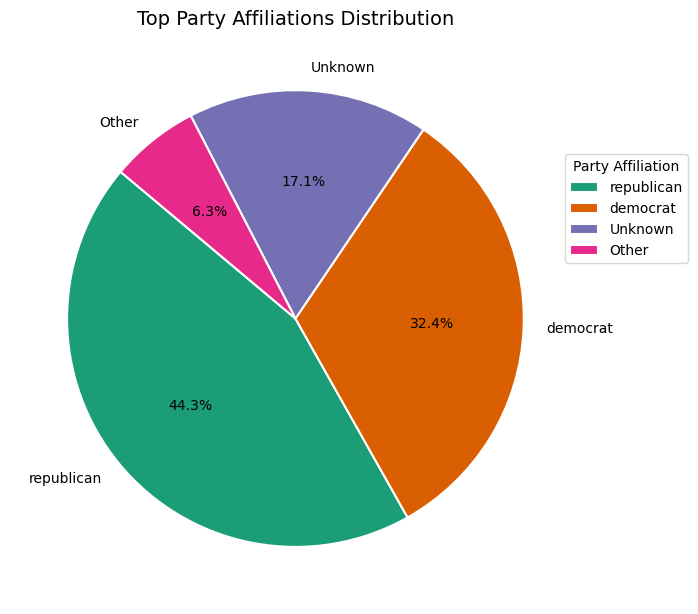

In [45]:
# Get the party affiliations
party_counts = df["party affiliation"].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
party_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.Dark2.colors  # Use a distinct colormap for clear slices
)

# Add title and legend
plt.title("Top Party Affiliations Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for cleaner appearance
plt.legend(party_counts.index, bbox_to_anchor=(1.2, 0.8), title="Party Affiliation")
plt.tight_layout()
plt.show()

6. venue Column

In [46]:
df["venue"] = df["venue"].apply(str)

vanueTokenize = []
for sen_tex in df['venue']:
    vanueTokenize.append(word_tokenize(sen_tex))

filteredVenues = []
for words in vanueTokenize:
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    filteredVenues.append(wordsFiltered)

index = 0    
for words in filteredVenues:
    vn=""
    for w in words: 
        vn=vn+ps.stem(w)+" "
    df.at[index, 'venue'] = vn
    index += 1

In [47]:
df["dummp"]=df["venue"]
df["dummp"]=df["dummp"].str.strip()
df.loc[df["dummp"].str.contains('confer|press|speech|interview|debate|broadcast|meet|opinion|statement|letter|ralli'), 'dummp'] = 'interview'
df.loc[df["dummp"].str.contains('campaign|ad|flier|commerci|mailer|panel|billboard'), 'dummp'] = 'ad'
df.loc[df["dummp"].str.contains('facebook|imag|media|meme|tweet|email|e-email|forum|blog|twitter'), 'dummp'] = 'social media'

df.loc[df["dummp"].str.contains('abc|articl|news|cnn|msnbc|book|journal|hbo|fox|column|newslett'), 'dummp'] = 'news'
df.loc[df["dummp"].str.contains('websit|web'), 'dummp'] = 'website'

df.loc[df["dummp"].str.contains('show'), 'dummp'] = 'show'

df.loc[df["dummp"].str.contains('unknown'), 'dummp'] = 'unknown'
df.loc[~df["dummp"].str.contains('interview|ad|social media|news|website|show|unknown'), 'dummp'] = 'other'

In [48]:
df["venue"]=df["dummp"]
df=df.drop(columns=['dummp'])

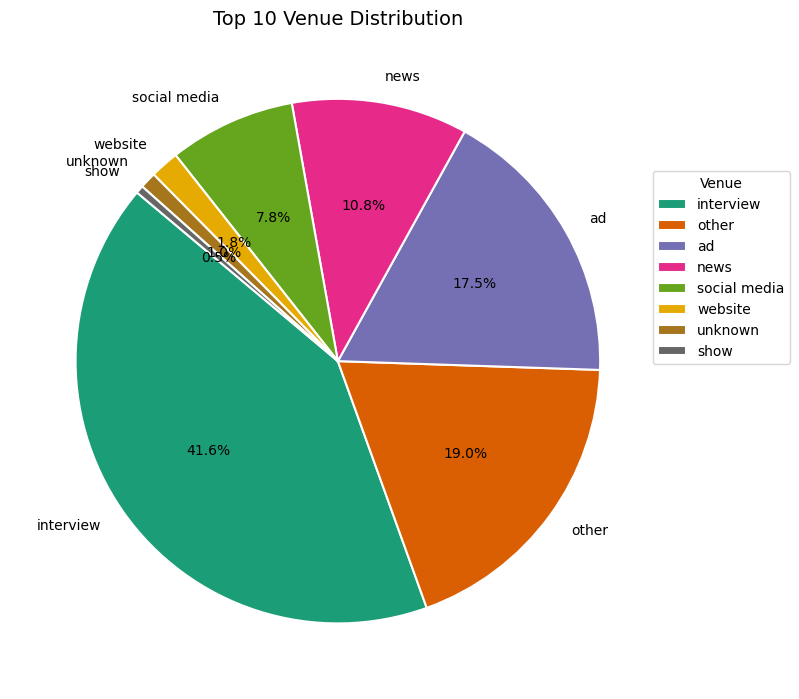

In [49]:
# Get the top 10 venue affiliations
party_counts = df["venue"].value_counts().head(10)

# Plot the pie chart
plt.figure(figsize=(8, 8))
party_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=plt.cm.Dark2.colors  # Use a distinct colormap for clear slices
)

# Add title and legend
plt.title("Top 10 Venue Distribution", fontsize=14)
plt.ylabel('')  # Remove ylabel for cleaner appearance
plt.legend(party_counts.index, bbox_to_anchor=(1.2, 0.8), title="Venue")
plt.tight_layout()
plt.show()

6. Numeric Columns

In [50]:
num=df[['barely true counts', 'false counts',
       'half true counts', 'mostly true counts', 'pants on fire counts']]
num=num.fillna(0)
num.head()

barely true counts  false counts  half true counts  mostly true counts  \
0                30.0          30.0              42.0                23.0   
1                 2.0           1.0               0.0                 0.0   
2                63.0         114.0              51.0                37.0   
3                 1.0           1.0               3.0                 1.0   
4                 5.0           7.0               2.0                 2.0   

   pants on fire counts  
0                  18.0  
1                   0.0  
2                  61.0  
3                   1.0  
4                   7.0

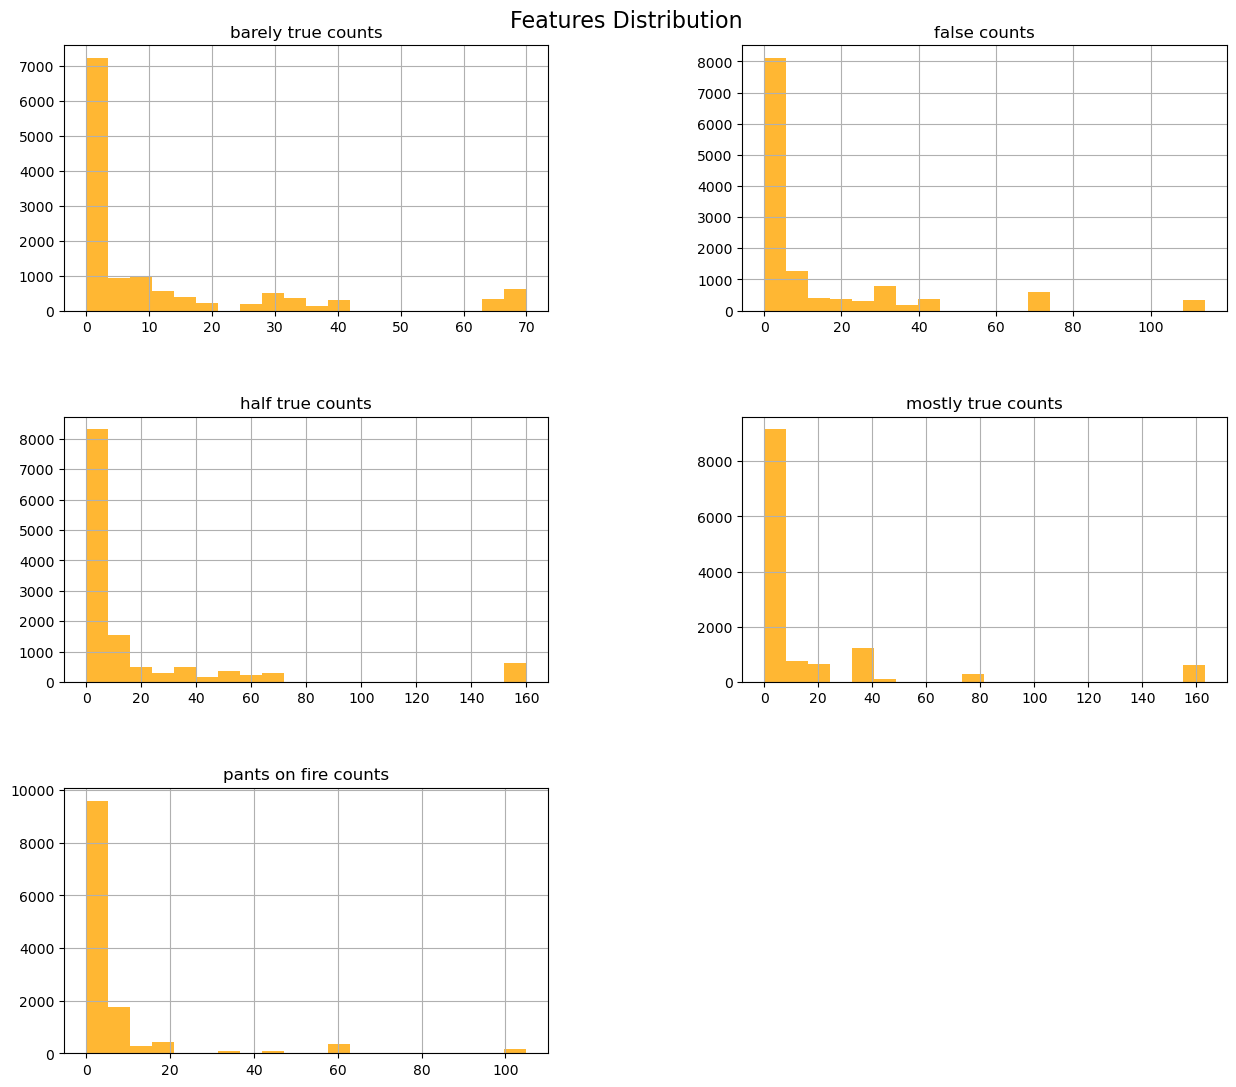

In [51]:
# Plot histogram for numerical features
num.hist(figsize=(15, 12), bins=20, color="orange", alpha=0.8)  # Adjust color and transparency

# Add title and labels
plt.suptitle("Features Distribution", fontsize=16)  # Supersedes subplot titles
plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.4)  # Adjust spacing between plots
plt.show()

In [52]:
df_bert["statement"] = df["statement"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x)) + " " + df["venue"].astype(str)

In [53]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(3, 3),
    max_features =5000)

Get_Vec= word_vectorizer.fit_transform(df['statement'].astype('str'))
Get_Vec= Get_Vec.toarray()

vocab1 = word_vectorizer.get_feature_names_out()
Features_vect=pd.DataFrame(np.round(Get_Vec, 1), columns=vocab1)

In [54]:
df=df.drop(columns=['statement'])
cleanup_nums = {
    "venue":{
        'interview': 0, 
        'ad': 1, 
        'social media': 2,
        'news': 3, 
        'website': 4, 
        'show': 5, 
        'unknown': -1 , 
        'other' : 6
    },
    "speaker's job title": {
        'state representative': 0, 
        'president': 1, 
        'office director': 2, 
        'company': 3,
        'U.S. representative': 4, 
        'government': 5, 
        'media':6, 
        'unknown': -1, 
        'other' : 7 
    },
    "party affiliation": {
        'republican': 0, 
        'democrat': 1, 
        'Unknown': -1,
        'Other': 2
    },
    "subject(s)": {
        'jobs':0, 
        'military':1, 
        'education':2, 
        'economy':3, 
        'government':4, 
        'health-care':5, 
        'crime':6, 
        'environment':7, 
        'budget':8, 
        'politics':9,
        'social':10, 
        'other':11
    }
}

df.replace(cleanup_nums, inplace=True)

In [55]:
df = pd.concat([df, Features_vect], axis=1)
x = pd.Categorical(df['speaker'])               
df['speaker']=x.codes
x = pd.Categorical(df['label'])               
df['label']=x.codes
x = pd.Categorical(df['state info'])               
df['state info']=x.codes


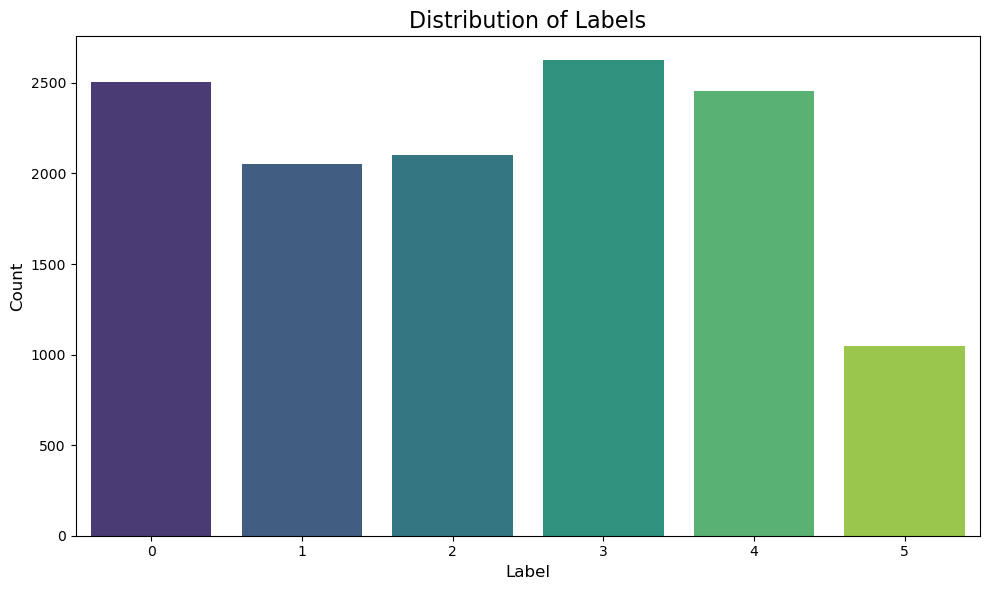

In [56]:
# Filter the DataFrame to exclude rows with label -1
df = df[df['label'] != -1]

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="label", palette="viridis")  # Use Seaborn palette for better aesthetics

# Add labels and title
plt.title("Distribution of Labels", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
results = []

### ML Models

### 1. Random Forest Machine Algorithm


KFold Split: 1
Training Random Forest...
CPU times: user 9.58 s, sys: 71.5 ms, total: 9.65 s
Wall time: 9.67 s

KFold Split: 2
Training Random Forest...
CPU times: user 9.64 s, sys: 53.1 ms, total: 9.7 s
Wall time: 9.7 s

KFold Split: 3
Training Random Forest...
CPU times: user 9.43 s, sys: 47.2 ms, total: 9.48 s
Wall time: 9.48 s

KFold Split: 4
Training Random Forest...
CPU times: user 9.59 s, sys: 56.7 ms, total: 9.65 s
Wall time: 9.65 s

KFold Split: 5
Training Random Forest...
CPU times: user 9.67 s, sys: 61.5 ms, total: 9.73 s
Wall time: 9.73 s


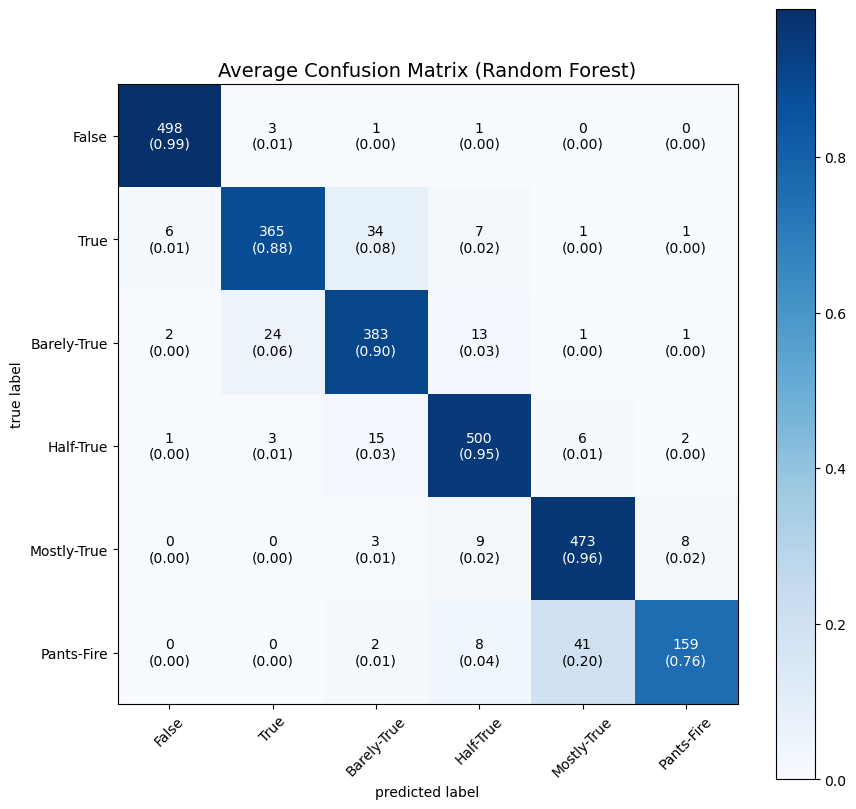


Total Average Metrics for Random Forest:
Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1-Score: 0.92
Validation Loss: 0.4792


In [63]:
results["Experiment1"] = {}
results["Experiment1"]["Model"] = "Random Forest Machine Algorithm"

# Start time
start_time = time.time()

# Define the class labels
labels = ['False', 'True', 'Barely-True', 'Half-True', 'Mostly-True', 'Pants-Fire']

# Initialize Random Forest Classifier
rf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, random_state=42)

# Extract features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.label.values  # Convert to NumPy array for compatibility

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outcomes1 = []  # To store accuracy for each fold
precision_scores = []
recall_scores = []
f1_scores = []
log_losses = []
conf_matrix_list_of_arrays = []  # To store confusion matrices for averaging
fold = 0

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    fold += 1
    print(f"\nKFold Split: {fold}")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model and measure execution time
    print("Training Random Forest...")
    %time rf.fit(X_train, y_train)

    # Make predictions
    predictions = rf.predict(X_test)
    probabilities = rf.predict_proba(X_test)  # Get probabilities for log loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    outcomes1.append(accuracy)

    # Calculate precision, recall, and F1-score (macro average)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    recall = recall_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculate log loss
    val_loss = log_loss(y_test, probabilities)
    log_losses.append(val_loss)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    conf_matrix_list_of_arrays.append(cm)

# Calculate average confusion matrix
avg_cm = np.mean(conf_matrix_list_of_arrays, axis=0)

# Round and convert to integer for display
avg_cm = np.ceil(avg_cm).astype(int)

# Plot average confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=avg_cm, figsize=(10, 10),
                                show_absolute=True, show_normed=True, colorbar=True)
ax.set_xticklabels([''] + labels, fontsize=10, rotation=45)
ax.set_yticklabels([''] + labels, fontsize=10)
plt.title("Average Confusion Matrix (Random Forest)", fontsize=14)
plt.show()

# Calculate overall metrics
mean_accuracy = np.mean(outcomes1)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_val_loss = np.mean(log_losses)

# Print overall metrics
print(f"\nTotal Average Metrics for Random Forest:")
print(f"Accuracy: {mean_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f}")
print(f"Recall: {mean_recall:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"Validation Loss: {mean_val_loss:.4f}")

# End time
end_time = time.time()

results["Experiment1"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'
results["Experiment1"]["Accuracy"] = mean_accuracy
results["Experiment1"]["Precision"] = mean_precision
results["Experiment1"]["Recall"] = mean_recall
results["Experiment1"]["F1-Score"] = mean_f1
results["Experiment1"]["Val Loss"] = mean_val_loss

### 2. Naive Bayes Machine Algorithm


KFold Split: 1
Training Naive Bayes...
CPU times: user 197 ms, sys: 203 ms, total: 400 ms
Wall time: 450 ms

KFold Split: 2
Training Naive Bayes...
CPU times: user 190 ms, sys: 91.3 ms, total: 282 ms
Wall time: 282 ms

KFold Split: 3
Training Naive Bayes...
CPU times: user 183 ms, sys: 81.8 ms, total: 265 ms
Wall time: 265 ms

KFold Split: 4
Training Naive Bayes...
CPU times: user 184 ms, sys: 97.4 ms, total: 281 ms
Wall time: 281 ms

KFold Split: 5
Training Naive Bayes...
CPU times: user 188 ms, sys: 95.2 ms, total: 284 ms
Wall time: 283 ms


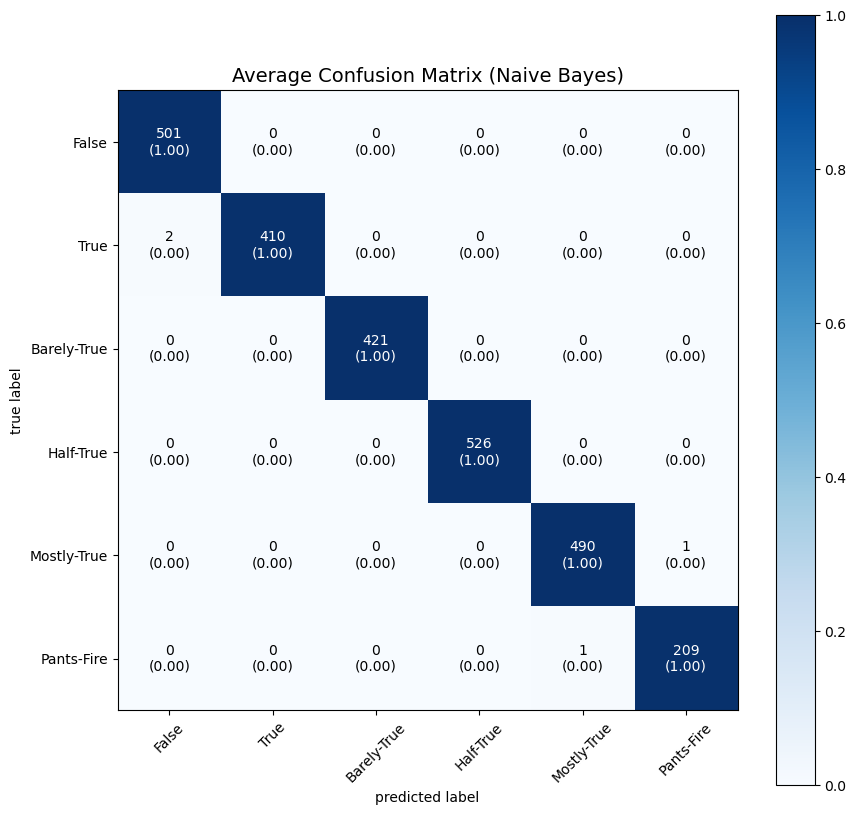


Total Average Metrics for Naive Bayes:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Validation Loss: 0.0036


In [62]:
results["Experiment2"] = {}
results["Experiment2"]["Model"] = "Naive Bayes Machine Algorithm"

# Start time
start_time = time.time()

# Define the class labels
labels = ['False', 'True', 'Barely-True', 'Half-True', 'Mostly-True', 'Pants-Fire']

# Initialize Gaussian Naive Bayes
nb = GaussianNB(var_smoothing=1e-08)

# Extract features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.label.values  # Convert to NumPy array for compatibility

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outcomes2 = []  # To store accuracy for each fold
precision_scores = []
recall_scores = []
f1_scores = []
log_losses = []
conf_matrix_list_of_arrays = []  # To store confusion matrices for averaging
fold = 0

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    fold += 1
    print(f"\nKFold Split: {fold}")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model and measure execution time
    print("Training Naive Bayes...")
    %time nb.fit(X_train, y_train)

    # Make predictions
    predictions = nb.predict(X_test)
    probabilities = nb.predict_proba(X_test)  # Get probabilities for log loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    outcomes2.append(accuracy)

    # Calculate precision, recall, and F1-score (macro average)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    recall = recall_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculate log loss
    val_loss = log_loss(y_test, probabilities)
    log_losses.append(val_loss)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    conf_matrix_list_of_arrays.append(cm)

# Calculate average confusion matrix
avg_cm = np.mean(conf_matrix_list_of_arrays, axis=0)

# Round and convert to integer for display
avg_cm = np.ceil(avg_cm).astype(int)

# Plot average confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=avg_cm, figsize=(10, 10),
                                show_absolute=True, show_normed=True, colorbar=True)
ax.set_xticklabels([''] + labels, fontsize=10, rotation=45)
ax.set_yticklabels([''] + labels, fontsize=10)
plt.title("Average Confusion Matrix (Naive Bayes)", fontsize=14)
plt.show()

# Calculate overall metrics
mean_accuracy = np.mean(outcomes2)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_val_loss = np.mean(log_losses)

# Print overall metrics
print(f"\nTotal Average Metrics for Naive Bayes:")
print(f"Accuracy: {mean_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f}")
print(f"Recall: {mean_recall:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"Validation Loss: {mean_val_loss:.4f}")

# End time
end_time = time.time()

results["Experiment2"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'
results["Experiment2"]["Accuracy"] = mean_accuracy
results["Experiment2"]["Precision"] = mean_precision
results["Experiment2"]["Recall"] = mean_recall
results["Experiment2"]["F1-Score"] = mean_f1
results["Experiment2"]["Val Loss"] = mean_val_loss

### 3. Decision trees Machine Algorithm


KFold Split: 1
Training Decision Tree...
CPU times: user 626 ms, sys: 58.4 ms, total: 685 ms
Wall time: 695 ms
Accuracy of KFold 1: 0.93

KFold Split: 2
Training Decision Tree...
CPU times: user 616 ms, sys: 28.5 ms, total: 645 ms
Wall time: 645 ms
Accuracy of KFold 2: 0.91

KFold Split: 3
Training Decision Tree...
CPU times: user 613 ms, sys: 27.1 ms, total: 640 ms
Wall time: 640 ms
Accuracy of KFold 3: 0.92

KFold Split: 4
Training Decision Tree...
CPU times: user 618 ms, sys: 20.6 ms, total: 639 ms
Wall time: 639 ms
Accuracy of KFold 4: 0.92

KFold Split: 5
Training Decision Tree...
CPU times: user 613 ms, sys: 32.3 ms, total: 646 ms
Wall time: 646 ms
Accuracy of KFold 5: 0.91


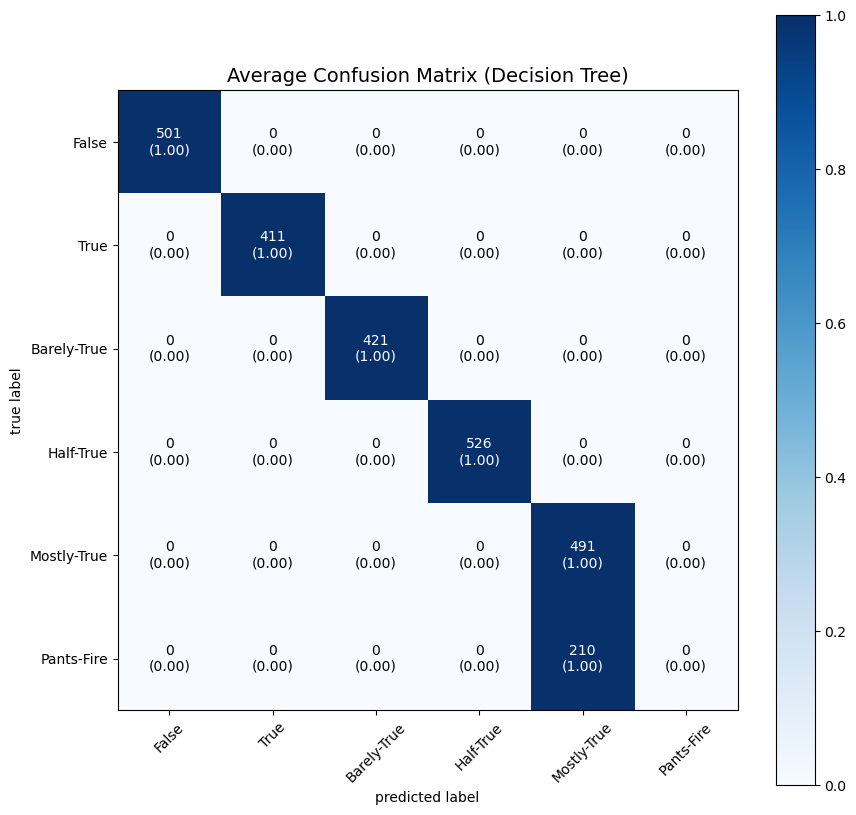


Total Average Metrics for Decision Tree:
Accuracy: 0.92
Precision: 0.86
Recall: 0.92
F1-Score: 0.88
Validation Loss: 0.1185


In [59]:
results["Experiment3"] = {}
results["Experiment3"]["Model"] = "Decision Trees Machine Algorithm"

# Start time
start_time = time.time()

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(min_samples_leaf=900)
labels = ['False', 'True', 'Barely-True', 'Half-True', 'Mostly-True', 'Pants-Fire']

# Extract features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.label.values  # Convert to NumPy array for compatibility

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outcomes3 = []  # To store accuracy for each fold
precision_list = []
recall_list = []
f1_list = []
val_loss_list = []
conf_matrix_list_of_arrays = []  # To store confusion matrices for averaging
fold = 0

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    fold += 1
    print(f"\nKFold Split: {fold}")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model and measure execution time
    print("Training Decision Tree...")
    %time dt.fit(X_train, y_train)

    # Make predictions
    predictions = dt.predict(X_test)
    probabilities = dt.predict_proba(X_test)  # For calculating log loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    outcomes3.append(accuracy)
    print(f"Accuracy of KFold {fold}: {accuracy:.2f}")

    # Calculate precision, recall, F1-score
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Store metrics
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Calculate log loss (validation loss)
    val_loss = log_loss(y_test, probabilities)
    val_loss_list.append(val_loss)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    conf_matrix_list_of_arrays.append(cm)

# Calculate average confusion matrix
avg_cm = np.mean(conf_matrix_list_of_arrays, axis=0)

# Round and convert to integer for display
avg_cm = np.ceil(avg_cm).astype(int)

# Plot average confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=avg_cm, figsize=(10, 10),
                                show_absolute=True, show_normed=True, colorbar=True)
ax.set_xticklabels([''] + labels, fontsize=10, rotation=45)
ax.set_yticklabels([''] + labels, fontsize=10)
plt.title("Average Confusion Matrix (Decision Tree)", fontsize=14)
plt.show()

# Calculate overall average metrics
mean_accuracy = np.mean(outcomes3)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)
mean_val_loss = np.mean(val_loss_list)

# Print overall metrics
print(f"\nTotal Average Metrics for Decision Tree:")
print(f"Accuracy: {mean_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f}")
print(f"Recall: {mean_recall:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"Validation Loss: {mean_val_loss:.4f}")

# End time
end_time = time.time()

results["Experiment3"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'
results["Experiment3"]["Accuracy"] = mean_accuracy
results["Experiment3"]["Precision"] = mean_precision
results["Experiment3"]["Recall"] = mean_recall
results["Experiment3"]["F1-Score"] = mean_f1
results["Experiment3"]["Val Loss"] = mean_val_loss

### 4. Neural networks Machine Algorithm


KFold Split: 1
Training Neural Network...
CPU times: user 42min, sys: 5min 34s, total: 47min 34s
Wall time: 6min 8s
Accuracy of KFold 1: 0.9945269741985927

KFold Split: 2
Training Neural Network...
CPU times: user 8min 1s, sys: 1min 3s, total: 9min 5s
Wall time: 1min 10s
Accuracy of KFold 2: 0.6969104419241299

KFold Split: 3
Training Neural Network...
CPU times: user 5.56 s, sys: 689 ms, total: 6.25 s
Wall time: 853 ms
Accuracy of KFold 3: 0.23308564724286274

KFold Split: 4
Training Neural Network...
CPU times: user 4.53 s, sys: 767 ms, total: 5.29 s
Wall time: 727 ms
Accuracy of KFold 4: 0.24090731325772388

KFold Split: 5
Training Neural Network...
CPU times: user 6.45 s, sys: 991 ms, total: 7.44 s
Wall time: 1 s
Accuracy of KFold 5: 0.18732890105592492


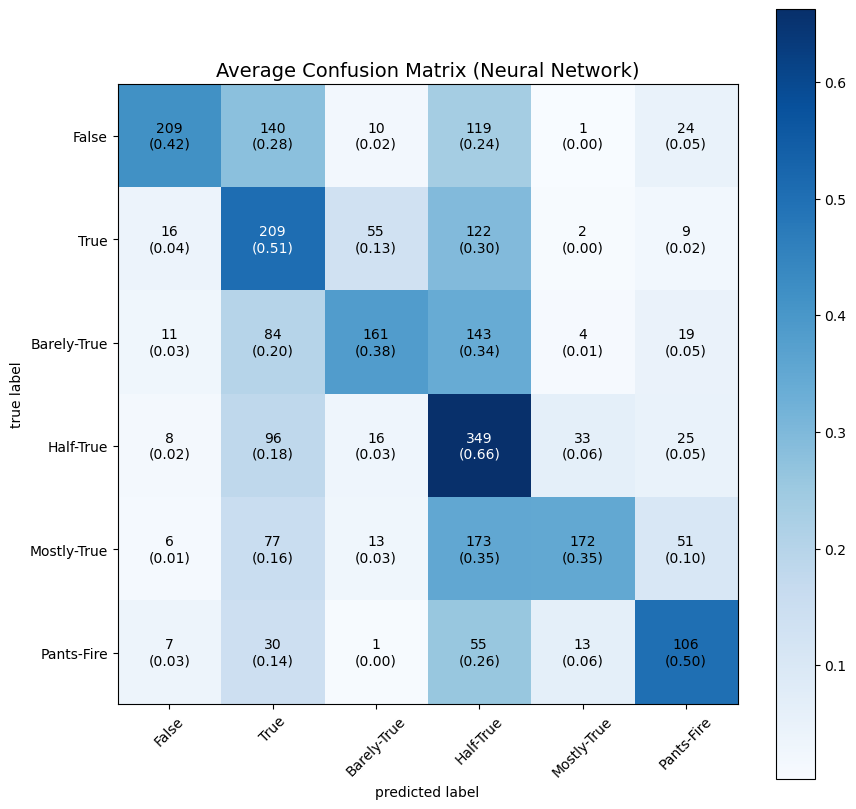


Total Average Metrics for Neural Network:
Accuracy: 0.47
Precision: 0.52
Recall: 0.47
F1-Score: 0.43
Validation Loss: 1.9317


In [66]:
results["Experiment4"] = {}
results["Experiment4"]["Model"] = "Neural Networks Architecture"

# Start time
start_time = time.time()

# Define the class labels
labels = ['False', 'True', 'Barely-True', 'Half-True', 'Mostly-True', 'Pants-Fire']

# Initialize the Neural Network classifier
nn = MLPClassifier(activation='relu', alpha=0.0001, batch_size=10, hidden_layer_sizes=(90,),
                   random_state=100, learning_rate='constant', learning_rate_init=0.001, max_iter=300)

# Extract features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.label.values  # Convert to NumPy array for compatibility

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outcomes4 = []  # To store accuracy for each fold
precision_scores = []
recall_scores = []
f1_scores = []
log_losses = []
conf_matrix_list_of_arrays = []  # To store confusion matrices for averaging
fold = 0
start_time = time.time()
# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    fold += 1
    print(f"\nKFold Split: {fold}")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model and measure execution time
    print("Training Neural Network...")
    %time nn.fit(X_train, y_train)

    # Make predictions
    predictions = nn.predict(X_test)
    probabilities = nn.predict_proba(X_test)  # Get probabilities for log loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    outcomes4.append(accuracy)
    print(f"Accuracy of KFold {fold}: {accuracy}")

    # Calculate precision, recall, and F1-score (macro average)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    recall = recall_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculate log loss
    val_loss = log_loss(y_test, probabilities)
    log_losses.append(val_loss)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    conf_matrix_list_of_arrays.append(cm)

# Calculate average confusion matrix
avg_cm = np.mean(conf_matrix_list_of_arrays, axis=0)

# Round and convert to integer for display
avg_cm = np.ceil(avg_cm).astype(int)

# Plot average confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=avg_cm, figsize=(10, 10),
                                show_absolute=True, show_normed=True, colorbar=True)
ax.set_xticklabels([''] + labels, fontsize=10, rotation=45)
ax.set_yticklabels([''] + labels, fontsize=10)
plt.title("Average Confusion Matrix (Neural Network)", fontsize=14)
plt.show()

# Calculate overall metrics
mean_accuracy = np.mean(outcomes4)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_val_loss = np.mean(log_losses)
end_time = time.time()
# Print overall metrics
print(f"\nTotal Average Metrics for Neural Network:")
print(f"Accuracy: {mean_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f}")
print(f"Recall: {mean_recall:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"Validation Loss: {mean_val_loss:.4f}")

# End time
end_time = time.time()

results["Experiment4"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'
results["Experiment4"]["Accuracy"] = mean_accuracy
results["Experiment4"]["Precision"] = mean_precision
results["Experiment4"]["Recall"] = mean_recall
results["Experiment4"]["F1-Score"] = mean_f1
results["Experiment4"]["Val Loss"] = mean_val_loss

5. BERT

In [65]:
texts = df_bert["statement"].tolist()  # Converts the 'statement' column into a list
labels = df_bert["label"].tolist()     # Converts the 'label' column into a list

In [66]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [83]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

class RoBERTaClassifier(nn.Module):
    def __init__(self, roberta_model_name, num_classes):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Output similar to BERT
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [84]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [85]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [86]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

In [87]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 5
learning_rate = 2e-5

In [88]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [89]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [91]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
results["Experiment5"] = {}
results["Experiment5"]["Model"] = "BERT Base Classifier"

# Start time
start_time = time.time()

outcomes5 = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

# End time
end_time = time.time()

results["Experiment5"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'
results["Experiment5"]["Accuracy"] = mean_accuracy
results["Experiment5"]["Precision"] = mean_precision
results["Experiment5"]["Recall"] = mean_recall
results["Experiment5"]["F1-Score"] = mean_f1
results["Experiment5"]["Val Loss"] = mean_val_loss

6. BERT RoBERTa

In [ ]:
roberta_model_name = 'roberta-base'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 5
learning_rate = 2e-5

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaClassifier(roberta_model_name, num_classes).to(device)

In [ ]:
results["Experiment6"] = {}
results["Experiment6"]["Model"] = "BERT RoBERTa Classifier"

# Start time
start_time = time.time()

outcomes6 = []
for epoch in range(num_epochs):
    # Measure how long the training epoch takes.
    t0 = time.time()
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    outcomes6.append(accuracy)
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

print('\n')
print('\n')
mean_outcome6 = np.mean(outcomes6)
print("Total Average Accuracy of BERT RoBERTa is : {0}".format(mean_outcome6)) 

### Result

In [ ]:
# Convert the dictionary to a DataFrame
resultDf = pd.DataFrame(results).T

In [ ]:
resultDf